In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Setting parameters
N = 15
J0 = 0.0
J = 1.0
beta = 1.0
partial_a = 2 # the number of neighbourhoods of factor node

## Caivity method

In [4]:
def messagePassing(N, weight):
    '''
        Parameters:
            N: the number of spins
            weight: the couplings alias for J_{ij}

        Return:
            F: free energy
    '''

    maxIteration = 1000
    eps = 1e-8
    lastF = 100000

    # initialize
    m = np.random.uniform(0, 1, (N, N)) # m_i_to_a can be viewed as i -> j (j is another neighbourhood of factor node a)
    mhat = np.random.uniform(0, 1, (N, N)) # m^\hat_a_to_i can be view as j -> i (j is another neighbourhood of factor node a)

    # iteration
    for i in range(maxIteration):
        # update m
        temp = np.arctanh(mhat)
        m = np.tanh(np.sum(temp, axis=0)[:, np.newaxis].repeat(N, axis=1) - temp.T)

        # update mhat
        mhat = np.tanh(beta * weight) * m.T

        # free energy
        DeltaF_a = np.log(np.cosh(beta * weight) * (1 + np.tanh(beta * weight) * m * m.T)) # shape = (N, N) means the neighbourhoods i, j with a
        Gamma_p = np.cosh(beta * weight) * (1 + np.tanh(beta * weight) * m)
        Gamma_m = np.cosh(beta * weight) * (1 - np.tanh(beta * weight) * m)
        DeltaF_i = np.log(np.prod(Gamma_p, axis=0) + np.prod(Gamma_m, axis=0))
        F = - (np.sum(DeltaF_i, axis=0) + (1 - partial_a) * np.sum(np.triu(DeltaF_a, 1))) / beta

        # print('interation {}: F = {}'.format(i, F))

        if np.abs(lastF - F) < eps:
            break
        lastF = F.copy()

    return F

## Enumeration

In [5]:
def enumeration(N, weight):
    sigma = np.zeros(N)
    Z = 0.0
    state = 0
    while (state >> N) != 1:
        for i in range(N):
            if ((state >> i) % 2) == 1:
                sigma[i] = 1
            else:
                sigma[i] = -1
        hamiltonian = - np.linalg.multi_dot((sigma, weight, sigma)) / 2
        Z += np.exp(-beta * hamiltonian)
        state += 1

    F = - np.log(Z) / beta
    return F

In [6]:
weight = np.random.normal(J0 / N, J / np.sqrt(N), size=(N, N))
weight = (weight + weight.T) / 2 - np.diag(np.diag(weight))

F = messagePassing(N, weight)
print("Cavity: {}".format(F))
F = enumeration(N, weight)
print("Enumeration: {}".format(F))

Cavity: -12.030276375172818
Enumeration: -11.91521748208238


In [7]:
betaList = np.arange(0.1, 5, 0.1)
freeEnergyBP = []
freeEnergyEnum = []
for beta in betaList:
    freeEnergyBP.append([])
    freeEnergyEnum.append([])
    for _ in range(100):
        weight = np.random.normal(J0 / N, J / np.sqrt(N), size=(N, N))
        weight = (weight + weight.T) / 2 - np.diag(np.diag(weight))

        freeEnergyBP[-1].append(messagePassing(N, weight))
        freeEnergyEnum[-1].append(enumeration(N, weight))

KeyboardInterrupt: 

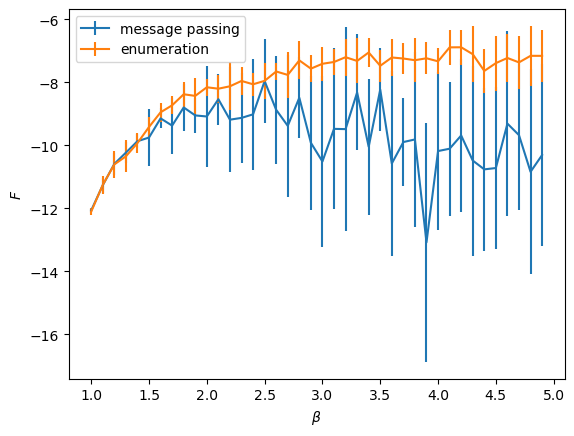

In [37]:
plt.errorbar(betaList, np.mean(freeEnergyBP, axis=1), np.std(freeEnergyBP, axis=1), label='message passing')
plt.errorbar(betaList, np.mean(freeEnergyEnum, axis=1), np.std(freeEnergyEnum, axis=1), label='enumeration')
plt.legend()
plt.xlabel('$\\beta$')
plt.ylabel('$F$')
plt.show()